# **League of Legends Worlds Match Predictor**

## *Models: Logistic Regression and Random Forest*


In [1]:
# importing all packages we need

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score,
classification_report,
roc_auc_score,
confusion_matrix,
roc_curve
)
import pickle
import warnings

warnings.filterwarnings('ignore')



## Loading the data set and filtering

In [2]:
def load_worlds_data():
    print("loading dataset")
    df = pd.read_csv('combined_dataset.csv')

    print(f"Total rows loaded: {len(df)}")

    # Check if necessary columns exist
    if 'year' in df.columns:
        print(f"Years in dataset: {sorted(df['year'].unique())}")

    # Check what leagues/tournaments exist
    if 'league' in df.columns:
        print(f"\nUnique leagues in data:")
        print(df['league'].value_counts().head(20))

    # Filter for Worlds Championship only
    if 'league' in df.columns:
        # Try different variations of "Worlds"
        worlds_df = df[
            df['league'].str.contains('World', case=False, na=False) |
            df['league'].str.contains('WCS', case=False, na=False) |
            df['league'].str.contains('International', case=False, na=False) |
            df['league'].str.contains('WLDs', case=False, na=False)
        ].copy()
        
        print(f"\nAfter filtering for Worlds: {len(worlds_df)} rows")
        
        # If no matches found, use ALL data (don't filter)
        if len(worlds_df) == 0:
            print("⚠️  No Worlds matches found with filter. Using ALL data instead.")
            print("You can manually filter your CSV to only include Worlds matches if needed.")
            worlds_df = df.copy()
    else:
        print("⚠️  No 'league' column found. Using all data.")
        worlds_df = df.copy()

    print(f"\nTotal matches to use: {len(worlds_df)}")
    if 'year' in worlds_df.columns and len(worlds_df) > 0:
        print(f"Years covered: {sorted(worlds_df['year'].unique())}")
        print(f"Rows per year:")
        print(worlds_df['year'].value_counts().sort_index())

    return worlds_df

## convert individual players' data into a team based format each game should have 2 rows (one per each team)

In [3]:
def prepare_team_level_data(df):
    print("getting team level data")
    
    # Filter for team-level rows (if data has position column)
    # Check what positions exist
    if 'position' in df.columns:
        print(f"Positions in data: {df['position'].unique()}")
        
        # Filter for team-level rows
        team_df = df[df['position'] == 'team'].copy()
        print(f"After filtering for 'team' position: {len(team_df)} rows")
        
        # If no team rows exist, keep all data (might already be team-level)
        if len(team_df) == 0:
            print("⚠️  No 'team' position found. Assuming data is already team-level or using all rows.")
            team_df = df.copy()
    else:
        print("No 'position' column found. Using all data as-is.")
        team_df = df.copy()

    print(f"Final team data shape: {team_df.shape}")
    return team_df

## Getting champion picks for each team

In [4]:
def create_champion_features(df):
    print("getting champion picks")
    if 'champion' in df.columns:
        # Create champion encoders
        le = LabelEncoder()
        all_champions = df['champion'].unique()
        le.fit(all_champions)
        
        df['champion_encoded'] = le.transform(df['champion'])
        
        # Save encoder for later use
        with open('champion_encoder.pkl', 'wb') as f:
            pickle.dump(le, f)

    return df

## Calculate team-level statistics

In [5]:
def calculate_team_stats(df):
    print("Calculating team stats")
    # Recent form (last 5 games for each team)
    df = df.sort_values(['teamname', 'date'])

    df['recent_win_rate'] = df.groupby('teamname')['result'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )

    df['recent_kills'] = df.groupby('teamname')['kills'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )

    df['recent_deaths'] = df.groupby('teamname')['deaths'].transform(
        lambda x: x.rolling(window=5, min_periods=1).mean()
    )

    # Overall team stats at Worlds
    team_overall = df.groupby('teamname').agg({
        'result': 'mean',
        'kills': 'mean',
        'deaths': 'mean',
        'gamelength': 'mean'
    }).add_suffix('_overall')

    df = df.merge(team_overall, left_on='teamname', right_index=True, how='left')

    return df

## Creating features based on team matchups

In [6]:
def create_matchup_features(df):
    print("Creating matchup features")

    # Side advantage (Blue vs Red)
    df['is_blue_side'] = (df['side'] == 'Blue').astype(int)

    # Regional encoding
    if 'league' in df.columns:
        region_encoder = LabelEncoder()
        df['region_encoded'] = region_encoder.fit_transform(df['league'])
        
        with open('region_encoder.pkl', 'wb') as f:
            pickle.dump(region_encoder, f)

    return df

## Preparing all of the features

In [7]:
def prepare_features(df):
    print("Creating features for modeling")

    # call all the feature creation functions
    df = create_champion_features(df)
    df = calculate_team_stats(df)
    df = create_matchup_features(df)

    # Fill missing values
    df = df.fillna(0)

    print(f"Features created. Dataset shape: {df.shape}")

    return df

## Creating visualizations 

In [8]:
def plot_data_exploration(df):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Win rate by side (red vs blue)
    if 'side' in df.columns:
        side_stats = df.groupby('side')['result'].mean()
        axes[0, 0].bar(side_stats.index, side_stats.values, color=['#4A90E2', '#E24A4A'])
        axes[0, 0].set_title('Win Rate by Side', fontsize=14, fontweight='bold')
        axes[0, 0].set_ylabel('Win Rate')
        axes[0, 0].set_ylim([0, 1])

    # Kills distribution by result
    if 'kills' in df.columns:
        df_wins = df[df['result'] == 1]['kills']
        df_losses = df[df['result'] == 0]['kills']
        axes[0, 1].hist([df_wins, df_losses], bins=20, label=['Wins', 'Losses'], alpha=0.7)
        axes[0, 1].set_title('Kills Distribution: Wins vs Losses', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Kills')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].legend()

    # Win rate over years
    if 'year' in df.columns:
        yearly_wins = df.groupby('year')['result'].mean()
        axes[1, 0].plot(yearly_wins.index, yearly_wins.values, marker='o', linewidth=2)
        axes[1, 0].set_title('Overall Win Rate by Year', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Year')
        axes[1, 0].set_ylabel('Win Rate')
        axes[1, 0].set_ylim([0, 1])
        axes[1, 0].grid(True, alpha=0.3)

    # Game length distribution
    if 'gamelength' in df.columns:
        axes[1, 1].hist(df['gamelength']/60, bins=30, color='skyblue', edgecolor='black')
        axes[1, 1].set_title('Game Length Distribution', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Game Length (minutes)')
        axes[1, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig('data_exploration.png', dpi=300, bbox_inches='tight')
    print("Saved: data_exploration.png")
    plt.show()


## Training models (Logitstic Regression and Random Forest)

In [9]:
def train_models(X_train, y_train, X_val, y_val):
    print("Training models")
    models = {
        "Logistic Regression": LogisticRegression(
            max_iter=1000, 
            random_state=42,
            solver='lbfgs'
        ),
        "Random Forest": RandomForestClassifier(
            n_estimators=200, 
            max_depth=10, 
            random_state=42,
            n_jobs=-1
        )
    }

    trained_models = {}
    results = {}


    for name, model in models.items():
        print(f"\nTraining {name}")
        
        # Train
        model.fit(X_train, y_train)
        
        # Predict
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        
        # Get probabilities for AUC
        y_train_proba = model.predict_proba(X_train)[:, 1]
        y_val_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate metrics
        train_acc = accuracy_score(y_train, y_train_pred)
        val_acc = accuracy_score(y_val, y_val_pred)
        train_auc = roc_auc_score(y_train, y_train_proba)
        val_auc = roc_auc_score(y_val, y_val_proba)
    
        results[name] = {
            'train_accuracy': train_acc,
            'val_accuracy': val_acc,
            'train_auc': train_auc,
            'val_auc': val_auc,
            'val_proba': y_val_proba
        }
        
        trained_models[name] = model
        
        print(f"Train Accuracy: {train_acc:.4f} | Val Accuracy: {val_acc:.4f}")
        print(f"Train AUC: {train_auc:.4f} | Val AUC: {val_auc:.4f}")

    # Print summary
    print("MODEL COMPARISON")
    results_df = pd.DataFrame({k: {m: v[m] for m in ['train_accuracy', 'val_accuracy', 'train_auc', 'val_auc']} 
                                for k, v in results.items()}).T
    print(results_df.sort_values('val_accuracy', ascending=False))

    # Select best model
    best_model_name = max(results, key=lambda x: results[x]['val_accuracy'])
    best_model = trained_models[best_model_name]

    print(f"Best Model: {best_model_name}")
    print(f"   Validation Accuracy: {results[best_model_name]['val_accuracy']:.4f}")

    return best_model, trained_models, results

## Creating visualizer to compare models

In [10]:
def plot_model_comparison(results):
    print("Creating model comparison plots")

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy comparison
    models = list(results.keys())
    train_accs = [results[m]['train_accuracy'] for m in models]
    val_accs = [results[m]['val_accuracy'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    axes[0].bar(x - width/2, train_accs, width, label='Train', alpha=0.8, color='#4A90E2')
    axes[0].bar(x + width/2, val_accs, width, label='Validation', alpha=0.8, color='#E24A4A')
    axes[0].set_xlabel('Model', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])

    # AUC comparison
    train_aucs = [results[m]['train_auc'] for m in models]
    val_aucs = [results[m]['val_auc'] for m in models]

    axes[1].bar(x - width/2, train_aucs, width, label='Train', alpha=0.8, color='#4A90E2')
    axes[1].bar(x + width/2, val_aucs, width, label='Validation', alpha=0.8, color='#E24A4A')
    axes[1].set_xlabel('Model', fontsize=12)
    axes[1].set_ylabel('AUC-ROC', fontsize=12)
    axes[1].set_title('Model AUC Comparison', fontsize=14, fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(models)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([0, 1])

    plt.tight_layout()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    print("Saved: model_comparison.png")
    plt.show()

## Creating ROC curves for the models

In [11]:
def plot_roc_curves(results, y_val):
    print("Creating ROC curve plots")

    plt.figure(figsize=(10, 8))

    # making it pretty with colors
    colors = ['#4A90E2', '#E24A4A']

    for (name, result), color in zip(results.items(), colors):
        fpr, tpr, _ = roc_curve(y_val, result['val_proba'])
        auc = result['val_auc']
        plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})', color=color)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
    print("Saved: roc_curves.png")
    plt.show()

## Creating confusion matrix

In [12]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    print(f"Creating confusion matrix for {model_name}")

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['Loss', 'Win'],
                yticklabels=['Loss', 'Win'],
                annot_kws={'size': 14})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)

    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    print("Saved: confusion_matrix.png")
    plt.show()

## Creating plot for feature importance (only for random forest)

In [13]:
def plot_feature_importance(model, feature_names, model_name, top_n=15):
    if hasattr(model, 'feature_importances_'):
        print(f"Creating feature importance for {model_name}")
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False).head(top_n)
        
        plt.figure(figsize=(10, 8))
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
        plt.barh(range(len(importance_df)), importance_df['importance'], color=colors)
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Importance', fontsize=12)
        plt.title(f'Top {top_n} Feature Importance - {model_name}', 
                fontsize=14, fontweight='bold')
        plt.gca().invert_yaxis()
        plt.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
        print("Saved: feature_importance.png")
        plt.show()

## Evaluation of the models

In [14]:
def evaluate_model(model, X_test, y_test, model_name="Best Model"):
    print(f"Evaluating {model_name}")

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC-ROC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Loss', 'Win']))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"True Negatives: {cm[0,0]}, False Positives: {cm[0,1]}")
    print(f"False Negatives: {cm[1,0]}, True Positives: {cm[1,1]}")

    # Visualize confusion matrix
    plot_confusion_matrix(y_test, y_pred, model_name)

    # Feature importance (only for Random Forest)
    if hasattr(model, 'feature_importances_'):
        print("\nTop 10 Most Important Features:")
        feature_importance = pd.DataFrame({
            'feature': X_test.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(feature_importance.head(10))
        
        # Plot feature importance
        plot_feature_importance(model, X_test.columns, model_name)

    return accuracy, auc

## Make predictions for outcome of a single match

In [15]:
def predict_match(model, team1_features, team2_features, team1_name, team2_name):
    
    # Prediction for both teams
    team1_win_prob = model.predict_proba([team1_features])[0][1]
    team2_win_prob = 1 - team1_win_prob

    print(f"Match Prediction: {team1_name} vs {team2_name}")
    print(f"{team1_name} Win Probability: {team1_win_prob:.2%}")
    print(f"{team2_name} Win Probability: {team2_win_prob:.2%}")
    print("\n")

    if team1_win_prob > 0.5:
        winner = team1_name 
    else:
        winner = team2_name
    
    confidence = max(team1_win_prob, team2_win_prob)

    print(f"Predicted Winner: {winner}")
    print(f"Confidence: {confidence:.2%}")
    print("\n")

    return {
        'team1': team1_name,
        'team2': team2_name,
        'team1_win_prob': team1_win_prob,
        'team2_win_prob': team2_win_prob,
        'predicted_winner': winner,
        'confidence': confidence
    }

## Getting features for a specific team based on their historial data

In [16]:
def get_team_features(team_name, df, feature_cols, scaler):

    # Get team's recent matches
    team_data = df[df['teamname'] == team_name].copy()

    if len(team_data) == 0:
        print(f"⚠️  Team '{team_name}' not found in dataset.")
        return None

    # Get most recent match features (as a baseline)
    team_data = team_data.sort_values('date', ascending=False)
    latest_features = team_data[feature_cols].iloc[0].values

    # Scale the features
    scaled_features = scaler.transform([latest_features])[0]

    return scaled_features

## Predicting the outcome of a match between two teams using both models

In [17]:
def predict_team_matchup(team1_name, team2_name, models_dict, df, feature_cols, scaler):
    print(f"PREDICTING: {team1_name} vs {team2_name}")

    # Handle case where a single model is passed instead of dict
    if not isinstance(models_dict, dict):
        print("⚠️  Single model passed, wrapping in dictionary...")
        models_dict = {'Model': models_dict}

    print(f"\n{'='*70}")
    print(f"PREDICTING: {team1_name} vs {team2_name}")
    print(f"{'='*70}")

    # Get features for both teams
    team1_features = get_team_features(team1_name, df, feature_cols, scaler)
    team2_features = get_team_features(team2_name, df, feature_cols, scaler)

    if team1_features is None or team2_features is None:
        print("Cannot make prediction - one or both teams not found.")
        return None

    # Display team stats
    team1_data = df[df['teamname'] == team1_name]
    team2_data = df[df['teamname'] == team2_name]

    print(f"\n{team1_name} Stats:")
    print(f"  Recent Win Rate: {team1_data['recent_win_rate'].iloc[-1]:.2%}")
    print(f"  Avg Kills: {team1_data['recent_kills'].iloc[-1]:.1f}")
    print(f"  Overall Win Rate: {team1_data['result_overall'].iloc[-1]:.2%}")

    print(f"\n{team2_name} Stats:")
    print(f"  Recent Win Rate: {team2_data['recent_win_rate'].iloc[-1]:.2%}")
    print(f"  Avg Kills: {team2_data['recent_kills'].iloc[-1]:.1f}")
    print(f"  Overall Win Rate: {team2_data['result_overall'].iloc[-1]:.2%}")

    # Make predictions with all models
    print(f"\n{'='*70}")
    if len(models_dict) > 1:
        print(f"PREDICTION RESULTS (BOTH MODELS):")
    else:
        print(f"PREDICTION RESULTS:")
    print(f"{'='*70}")

    results = {}

    for model_name, model in models_dict.items():
        # Make prediction (from team1's perspective)
        team1_win_prob = model.predict_proba([team1_features])[0][1]
        team2_win_prob = 1 - team1_win_prob
        
        winner = team1_name if team1_win_prob > 0.5 else team2_name
        confidence = max(team1_win_prob, team2_win_prob)
        
        results[model_name] = {
            'team1_win_prob': team1_win_prob,
            'team2_win_prob': team2_win_prob,
            'winner': winner,
            'confidence': confidence
        }
        
        print(f"\n{model_name}:")
        print(f"  {team1_name}: {team1_win_prob:.1%}")
        print(f"  {team2_name}: {team2_win_prob:.1%}")
        print(f"  Predicted Winner: {winner} (Confidence: {confidence:.1%})")

    # Ensemble prediction (average of both models) - only if multiple models
    if len(models_dict) > 1:
        avg_team1_prob = np.mean([results[m]['team1_win_prob'] for m in results])
        avg_team2_prob = 1 - avg_team1_prob
        ensemble_winner = team1_name if avg_team1_prob > 0.5 else team2_name
        ensemble_confidence = max(avg_team1_prob, avg_team2_prob)
        
        print(f"\n{'─'*70}")
        print(f"ENSEMBLE (Average of Both Models):")
        print(f"  {team1_name}: {avg_team1_prob:.1%}")
        print(f"  {team2_name}: {avg_team2_prob:.1%}")
        print(f"  Predicted Winner: {ensemble_winner} (Confidence: {ensemble_confidence:.1%})")

    print(f"{'='*70}\n")

    # Return results
    if len(models_dict) > 1:
        avg_team1_prob = np.mean([results[m]['team1_win_prob'] for m in results])
        avg_team2_prob = 1 - avg_team1_prob
        ensemble_winner = team1_name if avg_team1_prob > 0.5 else team2_name
        ensemble_confidence = max(avg_team1_prob, avg_team2_prob)
        
        return {
            'team1': team1_name,
            'team2': team2_name,
            'predictions': results,
            'ensemble': {
                'team1_win_prob': avg_team1_prob,
                'team2_win_prob': avg_team2_prob,
                'winner': ensemble_winner,
                'confidence': ensemble_confidence
            }
        }
    else:
        # Return single model result
        single_result = list(results.values())[0]
        return {
            'team1': team1_name,
            'team2': team2_name,
            'team1_win_prob': single_result['team1_win_prob'],
            'team2_win_prob': single_result['team2_win_prob'],
            'predicted_winner': single_result['winner'],
            'confidence': single_result['confidence']
        }

## Wrapping it all together (Main Function)

In [18]:
def main():
    print("="*60)
    print("LEAGUE OF LEGENDS WORLDS 2025 PREDICTOR")
    print("Models: Logistic Regression & Random Forest")
    print("="*60)    
    
    # 1. Load data
    df = load_worlds_data()
    df = prepare_team_level_data(df)

    # 2. Feature engineering
    df = prepare_features(df)

    # 3. Exploratory data analysis
    plot_data_exploration(df)

    # 4. Define features and target
    print("\n=== CHECKING AVAILABLE COLUMNS ===")
    print(f"Total columns in df: {len(df.columns)}")
    print(f"Available columns: {df.columns.tolist()}")

    # Define desired features
    desired_features = [
        'is_blue_side',
        'recent_win_rate',
        'recent_kills',
        'recent_deaths',
        'result_overall',
        'kills_overall',
        'deaths_overall',
        'gamelength_overall',
        'region_encoded'
    ]

    # Add champion features if available
    if 'champion_encoded' in df.columns:
        desired_features.append('champion_encoded')

    # Filter to only include available columns
    feature_cols = [col for col in desired_features if col in df.columns]

    print(f"\nDesired features: {desired_features}")
    print(f"Available features: {feature_cols}")
    print(f"Missing features: {[col for col in desired_features if col not in df.columns]}")

    if len(feature_cols) == 0:
        print("\nERROR: No features available! Check feature engineering step.")
        print("The following columns should have been created:")
        for col in desired_features:
            print(f"  - {col}: {'✓ EXISTS' if col in df.columns else '✗ MISSING'}")
        return

    # Check if result column exists
    if 'result' not in df.columns:
        print("\nERROR: 'result' column not found in dataframe!")
        print(f"Available columns: {df.columns.tolist()}")
        return

    X = df[feature_cols]
    y = df['result']

    print(f"\nFeatures selected: {len(feature_cols)}")
    print(f"Feature names: {feature_cols}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Non-null samples in X: {X.notna().all(axis=1).sum()}")
    print(f"Non-null samples in y: {y.notna().sum()}")

    # 5. Split data
    print(f"\nTotal samples before split: {len(X)}")
    print(f"Target distribution: {y.value_counts().to_dict()}")

    # Check if we have year column and enough data
    if 'year' in df.columns and df['year'].nunique() > 1:
        print(f"\nYear distribution in prepared data:")
        print(df['year'].value_counts().sort_index())
        
        # Use 2025 for test, everything else for train
        test_year = 2025
        train_df = df[df['year'] < test_year]
        test_df = df[df['year'] == test_year]
        
        print(f"\nTrain data (years < {test_year}): {len(train_df)} rows")
        print(f"Test data (year = {test_year}): {len(test_df)} rows")
        
        # Check if we have enough data in both sets
        if len(train_df) < 10:
            print("\n⚠️  Not enough training data. Using regular train/test split instead.")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
            )
        elif len(test_df) < 5:
            print(f"\n⚠️  Not enough test data for {test_year}. Using regular train/test split instead.")
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, stratify=y
            )
            X_train, X_val, y_train, y_val = train_test_split(
                X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
            )
        else:
            # Use year-based split
            X_train = train_df[feature_cols]
            y_train = train_df['result']
            X_test = test_df[feature_cols]
            y_test = test_df['result']
            
            print(f"Train set after feature selection: {len(X_train)} samples")
            print(f"Test set after feature selection: {len(X_test)} samples")
            
            # Further split training into train/val (if enough data)
            if len(X_train) > 10:
                X_train, X_val, y_train, y_val = train_test_split(
                    X_train, y_train, test_size=0.2, random_state=42
                )
            else:
                print("⚠️  Not enough train data to create validation set. Using all for training.")
                X_val, y_val = X_train, y_train
    else:
        # Regular train/test split
        print("\n⚠️  No year column found or only one year. Using regular train/test split.")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )

    print(f"\nTrain set: {len(X_train)} samples")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")

    # 6. Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Convert back to DataFrame to preserve column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

    # 7. Train models (Logistic Regression & Random Forest)
    best_model, all_models, results = train_models(
        X_train_scaled, y_train, 
        X_val_scaled, y_val
    )

    # 8. Visualize model comparison
    plot_model_comparison(results)
    plot_roc_curves(results, y_val)

    # 9. Evaluate on test set
    evaluate_model(best_model, X_test_scaled, y_test)

    # 10. Save both models
    print("\nSaving models...")
    for model_name, model in all_models.items():
        filename = f'{model_name.lower().replace(" ", "_")}_model.pkl'
        with open(filename, 'wb') as f:
            pickle.dump(model, f)
        print(f"Saved: {filename}")

    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Saved: scaler.pkl")

    with open('feature_columns.pkl', 'wb') as f:
        pickle.dump(feature_cols, f)
    print("Saved: feature_columns.pkl")

    # 11. Example prediction
    print("\n" + "="*60)
    print("EXAMPLE PREDICTION")
    print("="*60)
    print("\nTo predict a new match, prepare features in this order:")
    for i, col in enumerate(feature_cols, 1):
        print(f"{i}. {col}")


    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)

    # Print final summary
    print("\nFinal Model Performance Summary:")
    print("="*60)
    for name, result in results.items():
        print(f"\n{name}:")
        print(f"  Validation Accuracy: {result['val_accuracy']:.4f}")
        print(f"  Validation AUC: {result['val_auc']:.4f}")

    # Return objects needed for predictions
    return all_models, best_model, scaler, feature_cols, df

## Creating function to see specifc matchup prediction (after running the model)

In [19]:
def predict_matchup(team1_name, team2_name):

    models_dict = {}

    try:
        with open('logistic_regression_model.pkl', 'rb') as f:
            models_dict['Logistic Regression'] = pickle.load(f)
    except FileNotFoundError:
        print("⚠️  Logistic Regression model not found")

    try:
        with open('random_forest_model.pkl', 'rb') as f:
            models_dict['Random Forest'] = pickle.load(f)
    except FileNotFoundError:
        print("Random Forest model not found")

    if len(models_dict) == 0:
        print("No models found! Train the model first.")
        return None

    with open('scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    with open('feature_columns.pkl', 'rb') as f:
        feature_cols = pickle.load(f)

    # Load the data
    df = load_worlds_data()
    df = prepare_team_level_data(df)
    df = prepare_features(df)

    # Make prediction
    result = predict_team_matchup(team1_name, team2_name, models_dict, df, feature_cols, scaler)

    return result

## Running the code below

LEAGUE OF LEGENDS WORLDS 2025 PREDICTOR
Models: Logistic Regression & Random Forest
loading dataset
Total rows loaded: 785568
Years in dataset: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025), np.int64(2026)]

Unique leagues in data:
league
LDL       56244
LPL       54468
LCK       35568
LCKC      25992
VCS       20556
PCS       20448
PRM       19668
NACL      19572
LEC       19428
LAS       19176
LFL       17472
NLC       17160
LCS       16452
LJL       15816
TCL       15012
LVP SL    14700
LCSA      14040
CBLOL     13980
EM        13320
UPL       12612
Name: count, dtype: int64

After filtering for Worlds: 9060 rows

Total matches to use: 9060
Years covered: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Rows per year:
year
2020    1368
2021    1452
2022    1860
2023    1644
2024    1584
2025    1152
Name: count, dtype: int64
getting team level data
Positions in data: ['top' 'jng' 'mid' 

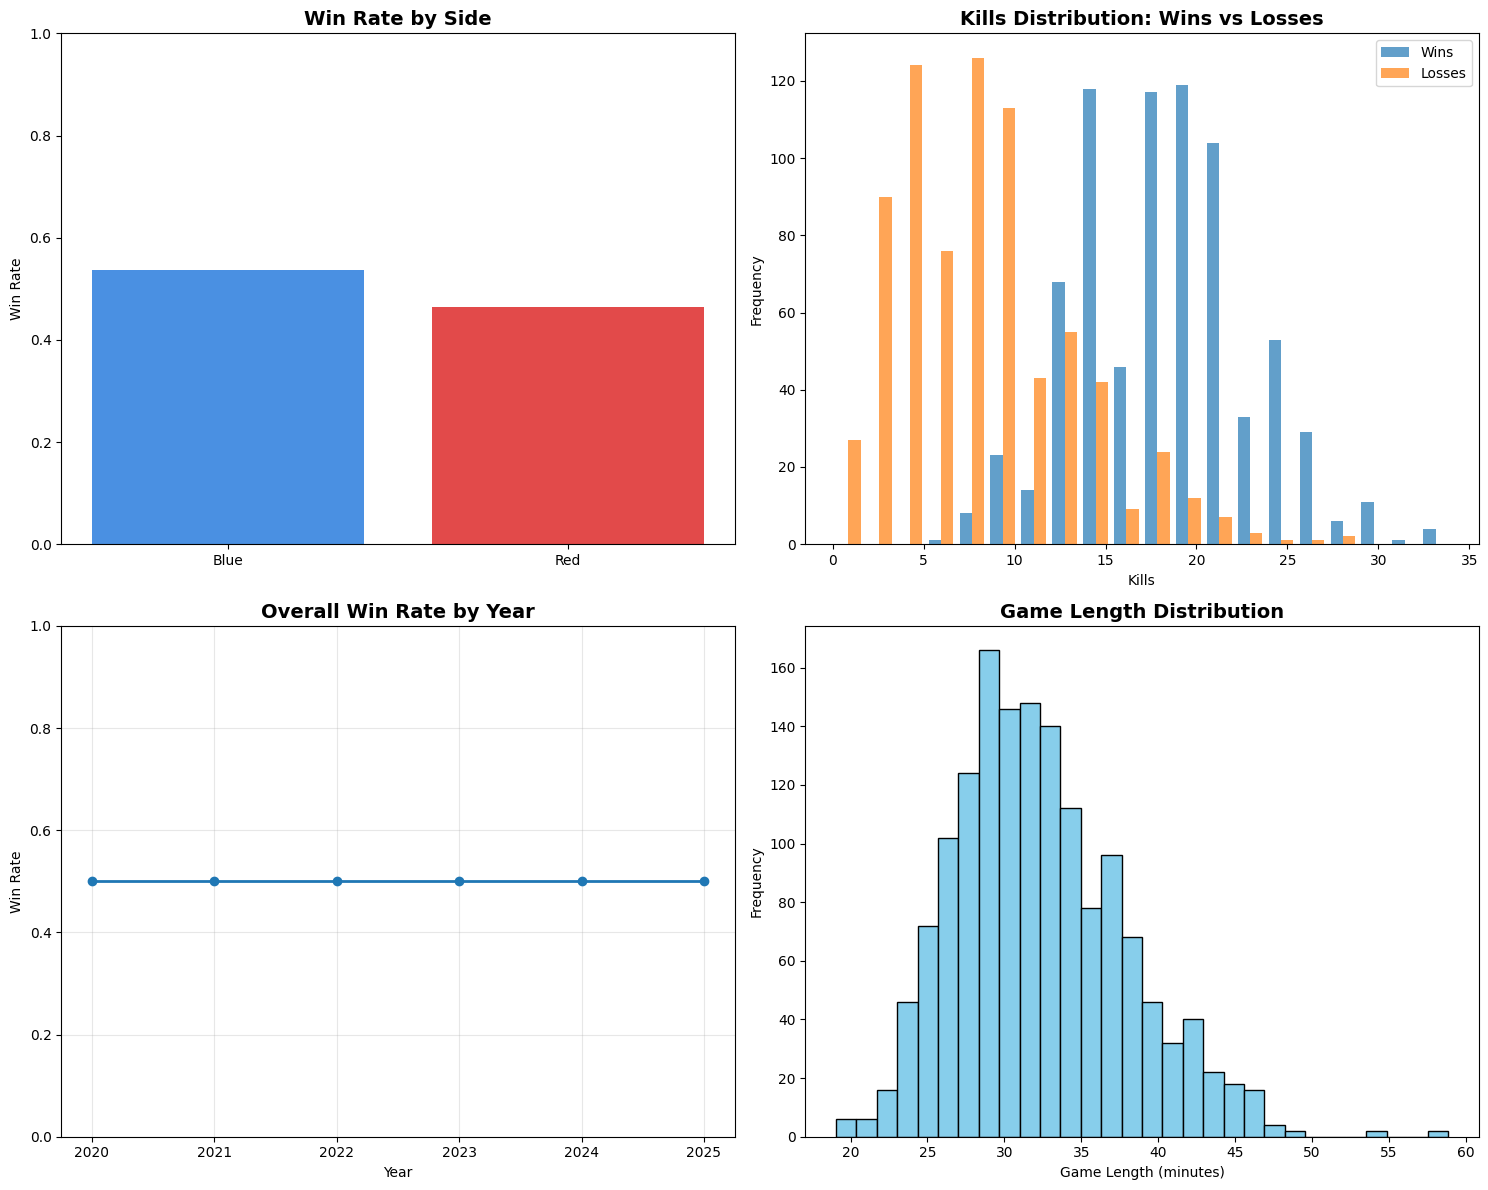


=== CHECKING AVAILABLE COLUMNS ===
Total columns in df: 174
Available columns: ['gameid', 'datacompleteness', 'url', 'league', 'year', 'split', 'playoffs', 'date', 'game', 'patch', 'participantid', 'side', 'position', 'playername', 'playerid', 'teamname', 'teamid', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4', 'pick5', 'gamelength', 'result', 'kills', 'deaths', 'assists', 'teamkills', 'teamdeaths', 'doublekills', 'triplekills', 'quadrakills', 'pentakills', 'firstblood', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim', 'team kpm', 'ckpm', 'firstdragon', 'dragons', 'opp_dragons', 'elementaldrakes', 'opp_elementaldrakes', 'infernals', 'mountains', 'clouds', 'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)', 'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds', 'void_grubs', 'opp_void_grubs', 'firstbaron', 'barons', 'opp_barons', 'atakhans', 'opp_atakhans', 'firsttower', 'towers', 'opp_towers', 'firstmidtower', 'first

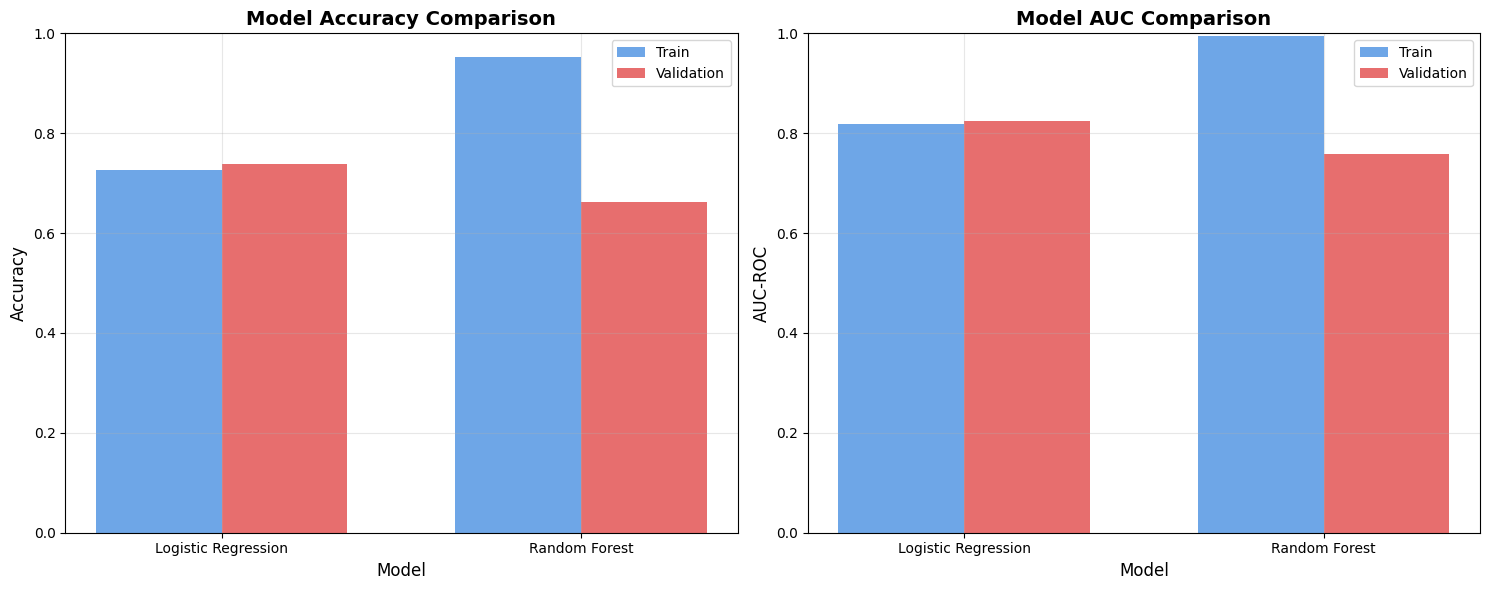

Creating ROC curve plots
Saved: roc_curves.png


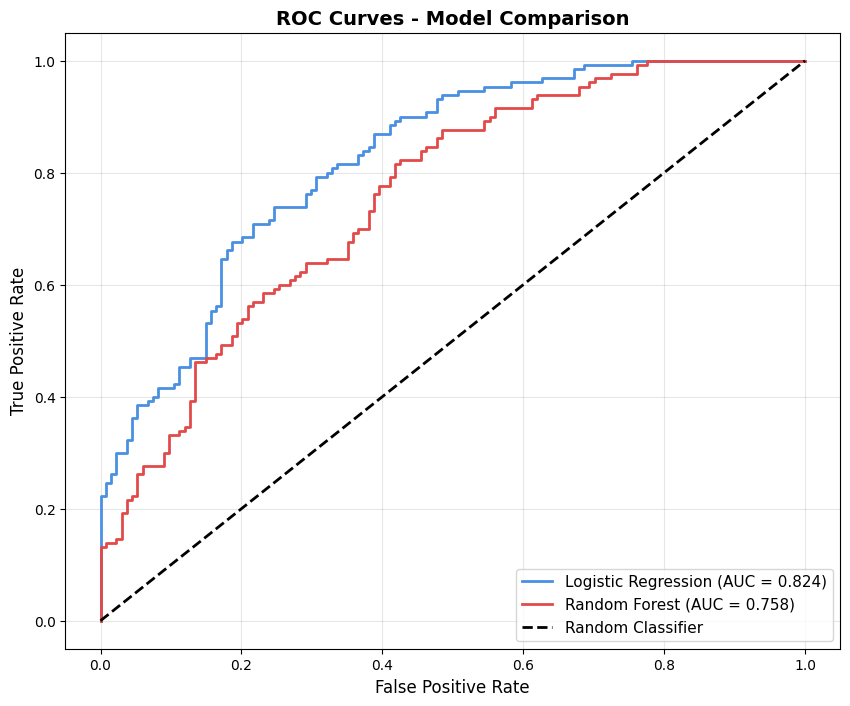

Evaluating Best Model
Accuracy: 0.6771
AUC-ROC: 0.7670

Classification Report:
              precision    recall  f1-score   support

        Loss       0.69      0.65      0.67        96
         Win       0.67      0.71      0.69        96

    accuracy                           0.68       192
   macro avg       0.68      0.68      0.68       192
weighted avg       0.68      0.68      0.68       192


Confusion Matrix:
[[62 34]
 [28 68]]
True Negatives: 62, False Positives: 34
False Negatives: 28, True Positives: 68
Creating confusion matrix for Best Model
Saved: confusion_matrix.png


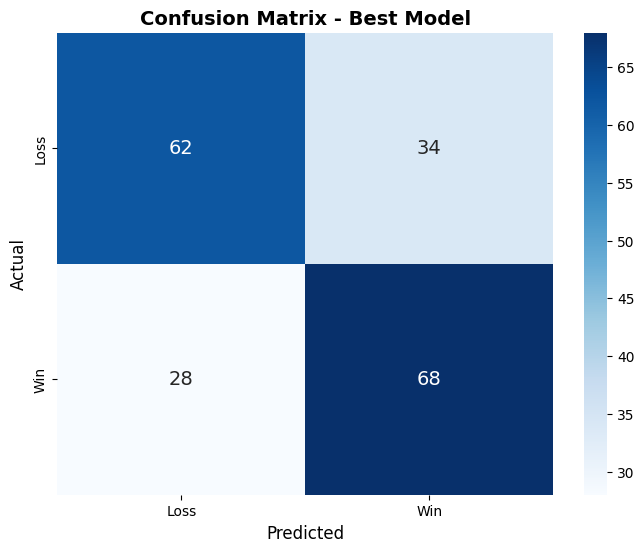


Saving models...
✅ Saved: logistic_regression_model.pkl
✅ Saved: random_forest_model.pkl
✅ Saved: scaler.pkl
✅ Saved: feature_columns.pkl

EXAMPLE PREDICTION

To predict a new match, prepare features in this order:
1. is_blue_side
2. recent_win_rate
3. recent_kills
4. recent_deaths
5. result_overall
6. kills_overall
7. deaths_overall
8. gamelength_overall
9. region_encoded
10. champion_encoded

TRAINING COMPLETE!

📊 Final Model Performance Summary:

Logistic Regression:
  Validation Accuracy: 0.7386
  Validation AUC: 0.8242

Random Forest:
  Validation Accuracy: 0.6629
  Validation AUC: 0.7578

EXAMPLE PREDICTIONS

Available teams (64):
 Index: 0 - 100 Thieves
 Index: 1 - Anyone's Legend
 Index: 2 - BNK FEARX
 Index: 3 - Beyond Gaming
 Index: 4 - Bilibili Gaming
 Index: 5 - CTBC Flying Oyster
 Index: 6 - Chiefs Esports Club
 Index: 7 - Cloud9
 Index: 8 - DRX
 Index: 9 - DetonatioN FocusMe
 Index: 10 - Dplus KIA
 Index: 11 - EDward Gaming
 Index: 12 - Evil Geniuses
 Index: 13 - FlyQues

In [23]:
if __name__ == "__main__":
    # This will load data, train models, and save them. all_models, best_model, scaler, feature_cols, and df will be returned for further use
    all_models, best_model, scaler, feature_cols, df = main()

    '''
    Below is if you want to make a prediction for a specific matchup after training 
    '''

    # List of available teams
    print("\n" + "="*70)
    print("EXAMPLE PREDICTIONS")
    print("="*70)
    
    available_teams = sorted(df['teamname'].unique())
    print(f"\nAvailable teams ({len(available_teams)}):")
    index = 0
    for team in available_teams:
        print(f" Index: {index} - {team}")
        index+=1 

    
    # Example predictions (change these team names to teams in your dataset)
    if len(available_teams) >= 2:
        print(f"\n{'='*70}")
        print("Making example prediction...")
        print(f"{'='*70}")
        
        # Use first two teams as example
        team1 = available_teams[0] # change to team wanted
        team2 = available_teams[1] # change to team wanted
        
        predict_team_matchup(team1, team2, best_model, df, feature_cols, scaler)